# Intro

In this project, we have been tasked with creating a model that correctly classifies whether a patient has pneumonia or not. We will use neural networks to classify the chest xray image of each patient to determine the diagnosis.

First, we will load the full dataset from Kaggle of the pneumonia images. Then we will preview some of the images and explore the distribution of classes. Then, we will iterate through a number of neural network models including convolutional neural network models and choose the model that performs best on our test set as our final model.

Before we get started, I want to note that we did not use the original split of data from Kaggle. We believed the validation set of images was too small (only 16 images) and in practice should have more data than the test set. Therefore, we moved 300 images from the test set (150 pneumonia and 150 normal) into the validation set in our folders. I have included this split in the repository for replication.

# Obtain

In [1]:
# import necessary libraries
# ! pip install tensorflow
# ! pip install keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

##  Load Image Data off the Local Disk

In [2]:
# use os module to obtain file paths to the images
main_directory = os.listdir('/Users/saman/x_ray_images/')
print(main_directory)

['test', 'train', 'val']


In [3]:
data_dir = '/Users/saman/x_ray_images/'
train_dir = os.path.join(data_dir, "train/")
test_dir = os.path.join(data_dir, "test/")
val_dir = os.path.join(data_dir, "val/")

In [4]:
# separate normal and pneumonia images

# train folder data
os.listdir(train_dir)
train_normal = train_dir + 'NORMAL/'
train_pneumo = train_dir + 'PNEUMONIA/'

# test folder data
os.listdir(test_dir)
test_normal = test_dir + 'NORMAL/'
test_pneumo = test_dir + 'PNEUMONIA/'

# val folder data
os.listdir(val_dir)
val_normal = val_dir + 'NORMAL/'
val_pneumo = val_dir + 'PNEUMONIA/'

In [5]:
# preview number of images in each category

print(f'There are {len(os.listdir(train_normal))} images in train normal.' )
print(f'There are {len(os.listdir(train_pneumo))} images in train pneumonia.' )
print(f'There are {len(os.listdir(train_pneumo))+len(os.listdir(train_normal))} total images in the train set.' )
print('\n')
print(f'There are {len(os.listdir(test_normal))} images in test normal.' )
print(f'There are {len(os.listdir(test_pneumo))} images in test pneumonia.' )
print(f'There are {len(os.listdir(test_pneumo))+len(os.listdir(test_normal))} total images in the test set.' )
print('\n')
print(f'There are {len(os.listdir(val_normal))} images in validation normal.' )
print(f'There are {len(os.listdir(val_pneumo))} images in validation pneumonia.' )
print(f'There are {len(os.listdir(val_pneumo))+len(os.listdir(val_normal))} total images in the validation set.' )

There are 1341 images in train normal.
There are 3875 images in train pneumonia.
There are 5216 total images in the train set.


There are 84 images in test normal.
There are 240 images in test pneumonia.
There are 324 total images in the test set.


There are 158 images in validation normal.
There are 158 images in validation pneumonia.
There are 316 total images in the validation set.


## Generate Image Data

Use the ImageDataGenerator to generate tensor image data in batches. Use the flow_from_directory method to take the path from the data folder to generate the batches of training, test and validation data. Since we need to reshape the image matrices before they are fed into the MLP model, we are going to take the entire data sample as our batch size in these generators. We will also reshape all of the images so that they are 150 x 150 pixels, and rescale the matrix values so that the values are on a scale of 0-1.

In [6]:
train_len = len(os.listdir(train_pneumo))+len(os.listdir(train_normal))
test_len = len(os.listdir(test_pneumo))+len(os.listdir(test_normal))
val_len = len(os.listdir(val_pneumo))+len(os.listdir(val_normal))

In [7]:
# set up parameters for data generators
# normalize RGB matrix values to be on 0-1 scale
rescale = 1./255
# reshape images to be 150 pixels x 150 pixels
target_size = 150,150

# need binary labels; 0 for normal, 1 for pneumonia
class_mode = 'binary'

In [8]:
train_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(train_dir,
                                                         target_size=(target_size),
                                                         batch_size=train_len,
                                                         class_mode=class_mode)

Found 5216 images belonging to 2 classes.


In [9]:
test_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(test_dir,
                                                         target_size=(target_size),
                                                         batch_size=test_len,
                                                         class_mode=class_mode)

Found 324 images belonging to 2 classes.


In [10]:
val_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(val_dir,
                                                         target_size=(target_size),
                                                         batch_size=val_len,
                                                         class_mode=class_mode)

Found 316 images belonging to 2 classes.


In [11]:
# Use next function to store a full batch of image and label data
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [12]:
m_train = train_images.shape[0]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 324
Number of validation samples: 316
train_images shape: (5216, 150, 150, 3)
train_labels shape: (5216,)
test_images shape: (324, 150, 150, 3)
test_labels shape: (324,)
val_images shape: (316, 150, 150, 3)
val_labels shape: (316,)


# Data Cleaning

## Previewing Images

In [13]:
# preview what binary labels belong to which image classification
class_dict = train_generator.class_indices 
class_dict

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
# function that returns the correct label name based on binary label
def return_key(val):
    for key, value in class_dict.items():
        if value==val:
            return key
    return('Key Not Found')

In [15]:
# function that returns image with the correct label

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip(images_arr, axes)):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(return_key(train_labels[i]))
    plt.tight_layout()
    plt.show()

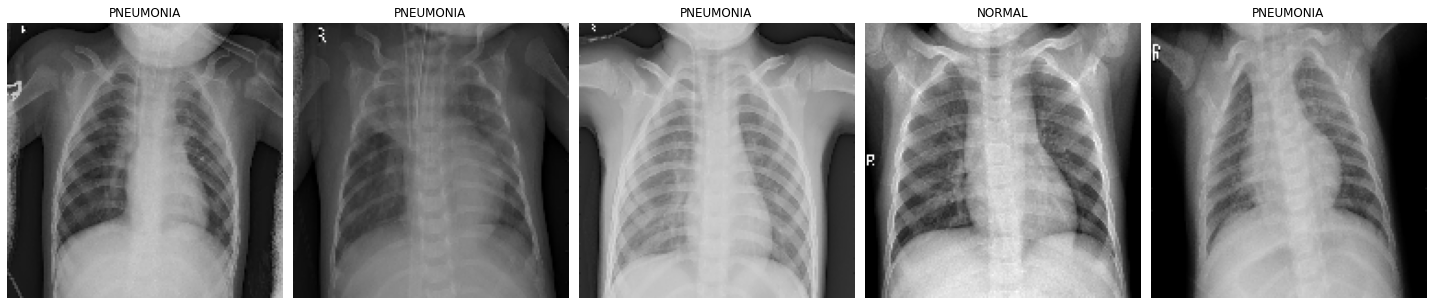

In [16]:
plotImages(train_images[:5])

In [17]:
train_labels[:5]

array([1., 1., 1., 0., 1.], dtype=float32)

According to our class indices, a value of 1 means the image is of pneumonia and 0 means the image is normal.

Now, reshape each image's matrix so it can be fed into the neural networks. The expected input shape is m x n, where n is the total number of elements in the feature vector for each image, or the number of rows after unrowing the 3 RGB 150x150 matrices.

In [18]:
train_images.shape

(5216, 150, 150, 3)

This matrix is in the format of (batch_size, pixel height, pixel width, 3 RGB matrices)

In [19]:
train_images_final = train_images.reshape(m_train,-1)
test_images_final = test_images.reshape(m_test,-1)
val_images_final = val_images.reshape(m_val,-1)

print(np.shape(train_images_final))
print(np.shape(test_images_final))
print(np.shape(val_images_final))

(5216, 67500)
(324, 67500)
(316, 67500)


Now our matrices are ready for input into the neural network.

## Explore Class Imbalance

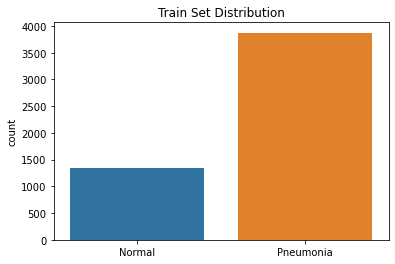

In [20]:
# need to set column names
ax = sns.countplot(x=pd.Series(train_labels))
ax.set_title('Train Set Distribution')
ax.set_xticklabels(['Normal', 'Pneumonia'])
plt.savefig('images/train_classes.png');

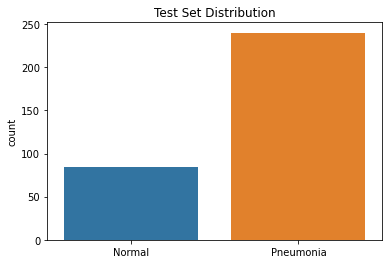

In [21]:
ax = sns.countplot(x=pd.Series(test_labels))
ax.set_title('Test Set Distribution')
ax.set_xticklabels(['Normal', 'Pneumonia'])
plt.savefig('images/test_classes.png');

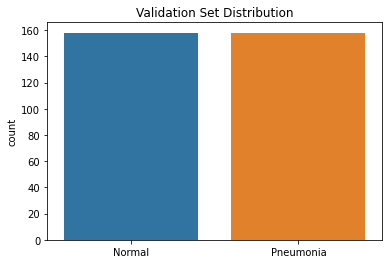

In [22]:
ax = sns.countplot(x=pd.Series(val_labels))
ax.set_title('Validation Set Distribution')
ax.set_xticklabels(['Normal', 'Pneumonia'])
plt.savefig('images/val_classes.png');

Both our training and test set have a clear class imbalance toward pneumonia. We will keep this in mind when interpretting our model results.

# Modeling

## Model 1: MLP

We are going to begin our modeling with a fully connected dense neural network, or a multi-level perceptron (MLP). See below for our initial parameters we are using in the model.

**Optimizer**: for our optimizer, which is the method used to minimize our cost function and update the weights of our model, we are using Stochastic Gradient Descent (SGD). With a batch size of 32, this is the number of samples used before calculating our loss and updating our weights (backward propagation). We are also going to use a decaying learning rate. Learning rates control by what factor weights are updated during backpropagation. Decaying learning rates use a larger learning rate to begin with, as we assume we are farther from the point of optimization. As we get closer to optimization, the learning rate decreases, which makes it less likely for us to overshoot our global minimum. We used an Exponential Decaying rate in this case.

**Loss Function**: The loss function we are trying to minimize in our model is binary cross-entropy, which is used when there are only two label classes (0 and 1) and computes the cross entropy loss between the true and predicted labels.

**Metrics**: we will use accuracy as the main performance metric tracked in all of our models, which is simply how frequently predictions equal labels.

**Activation Function**: The activation function is a function the output of each layer must go through before passing to the next layer. In our models, we will use Rectified Linear Unit (ReLu) as the activation function in all hidden layers and a sigmoid function as the activation function for our output layer.

**Batch Size**: Batch size is the number of training examples used in one forward and backward propagation. We will use the default batch size of 32, as this has been proven to work well in many cases. Smaller batch sizes can be noisier but can decrease overall overfitting.

**Epochs**: An epoch is a unit of one forward and backward propagation of all training examples. We will use 30 epochs in our models in the interest of time. We can run models with especially strong performance for 50 epochs and check those results. 

In [23]:
# set learning rate schedule using Exponential Decay
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    # start with .01 lr
    initial_learning_rate=.01,
    # decay by 0.9 ^(step/decay_steps)
    decay_steps=10000,
    decay_rate=0.9)

In [24]:
from keras.optimizers import SGD

opt = SGD(learning_rate=lr_schedule)
loss = 'binary_crossentropy'
metrics = ['accuracy']

To start with, we are going to run a baseline, fully connected model. This model will have limited layers and limited units.

In [25]:
# baseline fully connected model
input_shape = train_images_final.shape[1]

np.random.seed(123)

# initialize model
model_1 = Sequential()

# add 1 hidden dense layer to the network with 10 units to start
model_1.add(layers.Dense(10, activation='relu', input_shape=(input_shape,)))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [26]:
# Compile model, specify optimizer, loss function and metric
model_1.compile(optimizer=opt,
              loss= loss,
              metrics=metrics)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                675010    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 675,021
Trainable params: 675,021
Non-trainable params: 0
_________________________________________________________________


**Model Summary**: The model summary tells us how many parameters are in our model, in this case 675,021. For the first layer, this is calculated as 67500 weight inputs x 10 nodes, plus 10 bias terms. For the second layer, there are 10 weights resulting from the first layer plus 1 bias term, resulting in 11 parameters. This leads to a total of 675,021 parameters. As a neural network becomes more complicated, the number of parameters will increase.

In [27]:
#fit model
history_1 = model_1.fit(train_images_final,
                        train_labels,
                        batch_size=32,
                        epochs=30,
                        validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 4s 22ms/step - loss: 0.6174 - accuracy: 0.7223 - val_loss: 0.6817 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 2s 12ms/step - loss: 0.3475 - accuracy: 0.8280 - val_loss: 1.0834 - val_accuracy: 0.5570
Epoch 3/30
163/163 [==============================] - 2s 13ms/step - loss: 0.3289 - accuracy: 0.8885 - val_loss: 0.8785 - val_accuracy: 0.6487
Epoch 4/30
163/163 [==============================] - 2s 12ms/step - loss: 0.2863 - accuracy: 0.9036 - val_loss: 1.1709 - val_accuracy: 0.6013
Epoch 5/30
163/163 [==============================] - 2s 12ms/step - loss: 0.2564 - accuracy: 0.9216 - val_loss: 0.5376 - val_accuracy: 0.7500
Epoch 6/30
163/163 [==============================] - 2s 12ms/step - loss: 0.2523 - accuracy: 0.9157 - val_loss: 0.6198 - val_accuracy: 0.7373
Epoch 7/30
163/163 [==============================] - 2s 12ms/step - loss: 0.2246 - accuracy: 0.9342 - val_loss: 0.8261 - val_accuracy: 0.6962

In [196]:
# create function for visualizing training results
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('images/loss_graph.png')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('images/acc_graph.png')
    plt.show()

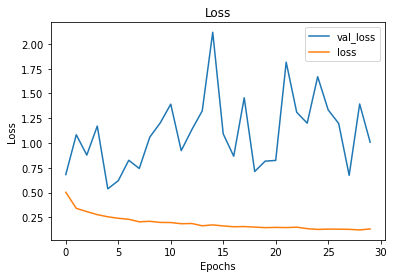

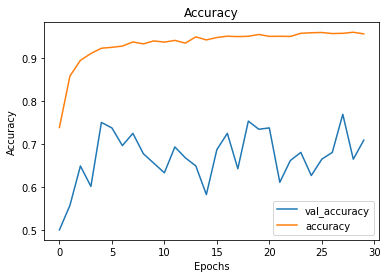

In [29]:
visualize_training_results(history_1)

In [30]:
# create model results function to return
def model_results(model):
    train_loss, train_acc = model.evaluate(train_images_final, train_labels, batch_size=32)
    val_loss, val_acc = model.evaluate(val_images_final, val_labels, batch_size=32)
    test_loss, test_acc = model.evaluate(test_images_final, test_labels, batch_size=32)
    print(f"training loss:{round(train_loss,2)}, training accuracy:{round(train_acc,2)}")
    
    print(f"validation loss:{round(val_loss,2)}, validation accuracy:{round(val_acc,2)}")
    
    print(f"testing loss:{round(test_loss,2)}, testing accuracy:{round(test_acc,2)}")

In [31]:
model_results(model_1)

11/11 [==============================] - 0s 7ms/step - loss: 0.5138 - accuracy: 0.8426
training loss:0.12, training accuracy:0.96
validation loss:1.01, validation accuracy:0.71
testing loss:0.51, testing accuracy:0.84


This model has high performance on the training data, but it does not appear to be converging on the validation set. Although we will definitely need to handle some of the overfitting in this model, let's tune the number of layers and units in our model and see how it changes our results.

## Model 2: Determine Number of Layers

In [34]:
np.random.seed(123)

# initialize model
model_2 = Sequential()
# add Dense layers to the network
model_2.add(layers.Dense(10, activation='relu', input_shape=(input_shape,)))
# add two additional hidden layers to our network
model_2.add(layers.Dense(7, activation='relu'))
model_2.add(layers.Dense(5, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [35]:
# Compile model, specify loss function
model_2.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_2 = model_2.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 3s 13ms/step - loss: 0.5670 - accuracy: 0.7658 - val_loss: 0.9898 - val_accuracy: 0.5127
Epoch 2/30
163/163 [==============================] - 2s 12ms/step - loss: 0.3589 - accuracy: 0.8643 - val_loss: 1.1257 - val_accuracy: 0.5633
Epoch 3/30
163/163 [==============================] - 2s 11ms/step - loss: 0.3114 - accuracy: 0.8868 - val_loss: 0.7152 - val_accuracy: 0.7057
Epoch 4/30
163/163 [==============================] - 2s 12ms/step - loss: 0.2667 - accuracy: 0.9198 - val_loss: 0.6257 - val_accuracy: 0.7373
Epoch 5/30
163/163 [==============================] - 2s 11ms/step - loss: 0.2491 - accuracy: 0.9267 - val_loss: 1.1810 - val_accuracy: 0.6424
Epoch 6/30
163/163 [==============================] - 2s 11ms/step - loss: 0.2329 - accuracy: 0.9302 - val_loss: 1.1650 - val_accuracy: 0.6392
Epoch 7/30
163/163 [==============================] - 2s 11ms/step - loss: 0.2220 - accuracy: 0.9341 - val_loss: 1.4815 - val_accuracy: 0.6171

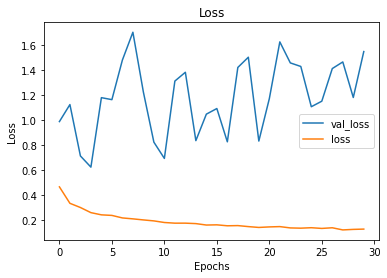

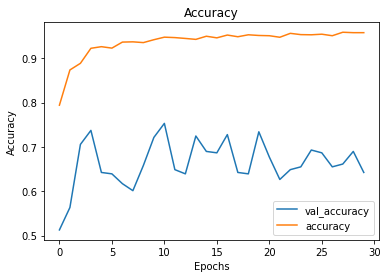

In [36]:
visualize_training_results(history_2)

In [37]:
model_results(model_2)

11/11 [==============================] - 0s 5ms/step - loss: 0.8075 - accuracy: 0.8117
training loss:0.12, training accuracy:0.96
validation loss:1.55, validation accuracy:0.64
testing loss:0.81, testing accuracy:0.81


Our accuracy scores and loss for the validation and test set got worse. Let's see if changing the number of units would improve our scores at all.

## Model 3: Determine Number of Units

In [40]:
np.random.seed(123)

# initialize model
model_3 = Sequential()
# add Dense layers to the network
model_3.add(layers.Dense(20, activation='relu', input_shape=(input_shape,)))
# add additional layer
model_3.add(layers.Dense(10, activation='relu'))
model_3.add(layers.Dense(7, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [41]:
model_3.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_3 = model_3.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 3s 16ms/step - loss: 0.8902 - accuracy: 0.7030 - val_loss: 0.5594 - val_accuracy: 0.7468
Epoch 2/30
163/163 [==============================] - 2s 14ms/step - loss: 0.3930 - accuracy: 0.8310 - val_loss: 0.7589 - val_accuracy: 0.6424
Epoch 3/30
163/163 [==============================] - 2s 15ms/step - loss: 0.2899 - accuracy: 0.9066 - val_loss: 0.5257 - val_accuracy: 0.7911
Epoch 4/30
163/163 [==============================] - 2s 15ms/step - loss: 0.2705 - accuracy: 0.9091 - val_loss: 0.7599 - val_accuracy: 0.6962
Epoch 5/30
163/163 [==============================] - 2s 14ms/step - loss: 0.2698 - accuracy: 0.9077 - val_loss: 0.8487 - val_accuracy: 0.6930
Epoch 6/30
163/163 [==============================] - 2s 14ms/step - loss: 0.2552 - accuracy: 0.9082 - val_loss: 0.9480 - val_accuracy: 0.6741
Epoch 7/30
163/163 [==============================] - 2s 14ms/step - loss: 0.2102 - accuracy: 0.9366 - val_loss: 0.9910 - val_accuracy: 0.6772

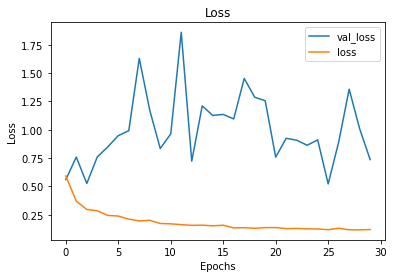

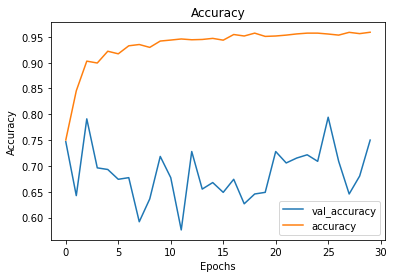

In [42]:
visualize_training_results(history_3)

In [43]:
model_results(model_3)

11/11 [==============================] - 0s 6ms/step - loss: 0.3775 - accuracy: 0.8519
training loss:0.14, training accuracy:0.95
validation loss:0.74, validation accuracy:0.75
testing loss:0.38, testing accuracy:0.85


We achieved slightly better results on our validation and test results. However, there is still a clear difference between or training and validation results, a sign of significant overfitting. Let's see if applying different strategies of regularization can improve this overfitting.

## Model 4: Early Stopping

Early stopping is a regularization method that works by stopping model training once the model performance stops improving on a hold out validation set.

In [166]:
np.random.seed(123)

# initialize model
model_4 = Sequential()
# add Dense layers to the network
model_4.add(layers.Dense(20, activation='relu', input_shape=(input_shape,)))
# add additional layers
model_4.add(layers.Dense(10, activation='relu'))
model_4.add(layers.Dense(7, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [167]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# implement early stopping, monitoring val loss and training for 10 epochs before stopping
# use model checkpoint to save the model resulting from early stopping
early_stopping = [EarlyStopping(monitor='val_loss',patience=10),
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [168]:
model_4.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_4 = model_4.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32, callbacks=early_stopping,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 75s 441ms/step - loss: 0.6718 - accuracy: 0.6898 - val_loss: 0.7196 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 3s 16ms/step - loss: 0.4746 - accuracy: 0.7695 - val_loss: 0.8682 - val_accuracy: 0.5032
Epoch 3/30
163/163 [==============================] - 3s 17ms/step - loss: 0.3574 - accuracy: 0.8547 - val_loss: 0.5128 - val_accuracy: 0.7722
Epoch 4/30
163/163 [==============================] - 3s 16ms/step - loss: 0.3486 - accuracy: 0.8710 - val_loss: 1.1419 - val_accuracy: 0.5253
Epoch 5/30
163/163 [==============================] - 3s 20ms/step - loss: 0.2488 - accuracy: 0.9268 - val_loss: 0.7012 - val_accuracy: 0.7025
Epoch 6/30
163/163 [==============================] - 3s 17ms/step - loss: 0.2224 - accuracy: 0.9365 - val_loss: 0.7398 - val_accuracy: 0.6962
Epoch 7/30
163/163 [==============================] - 3s 19ms/step - loss: 0.2053 - accuracy: 0.9327 - val_loss: 0.9737 - val_accuracy: 0.66

In [173]:
from keras.models import load_model
model_4 = load_model('best_model.h5')

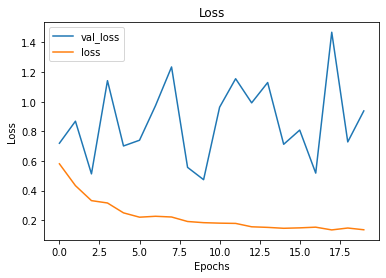

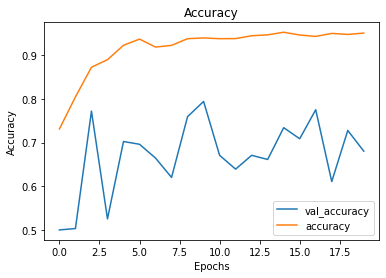

In [175]:
visualize_training_results(history_4)

In [174]:
model_results(model_4)

11/11 [==============================] - 1s 28ms/step - loss: 0.3297 - accuracy: 0.8488
training loss:0.26, training accuracy:0.9
validation loss:0.47, validation accuracy:0.79
testing loss:0.33, testing accuracy:0.85


Although we lost some of our training accuracy, these are the best validation results we've received yet, with loss of 0.47 and accuracy of .79. We are getting closer to our training values. Let's see if any other regularization strategies work better.

## Model 5: L2 Regularization

L2 Regularization is the most common type of regularization, which penalizes weight matrices for being too large, forcing the network to be simplified.

In [171]:
from keras import regularizers

np.random.seed(123)

# initialize model
model_5 = Sequential()
# add Dense layers to the network
model_5.add(layers.Dense(20, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(.005)))
model_5.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_5.add(layers.Dense(7, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_5.add(layers.Dense(1, activation='sigmoid'))

In [172]:
model_5.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_5 = model_5.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 128s 139ms/step - loss: 0.8613 - accuracy: 0.7370 - val_loss: 0.9536 - val_accuracy: 0.6076
Epoch 2/30
163/163 [==============================] - 4s 24ms/step - loss: 0.6552 - accuracy: 0.8641 - val_loss: 1.1444 - val_accuracy: 0.5981
Epoch 3/30
163/163 [==============================] - 4s 25ms/step - loss: 0.5972 - accuracy: 0.8888 - val_loss: 1.1164 - val_accuracy: 0.6582
Epoch 4/30
163/163 [==============================] - 4s 23ms/step - loss: 0.5511 - accuracy: 0.9110 - val_loss: 0.8776 - val_accuracy: 0.7215
Epoch 5/30
163/163 [==============================] - 3s 21ms/step - loss: 0.5299 - accuracy: 0.9127 - val_loss: 0.9302 - val_accuracy: 0.7120
Epoch 6/30
163/163 [==============================] - 4s 24ms/step - loss: 0.4898 - accuracy: 0.9256 - val_loss: 1.2197 - val_accuracy: 0.6772
Epoch 7/30
163/163 [==============================] - 4s 25ms/step - loss: 0.4659 - accuracy: 0.9292 - val_loss: 1.3958 - val_accuracy: 0.6

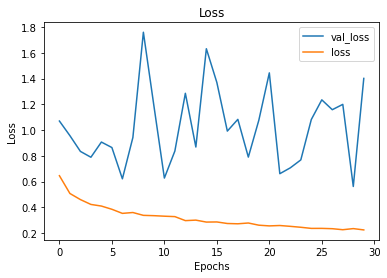

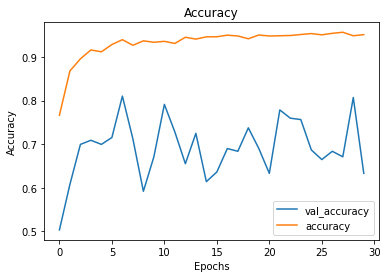

In [54]:
visualize_training_results(history_5)

In [55]:
model_results(model_5)

11/11 [==============================] - 0s 6ms/step - loss: 0.7921 - accuracy: 0.8025
training loss:0.21, training accuracy:0.96
validation loss:1.4, validation accuracy:0.63
testing loss:0.79, testing accuracy:0.8


Using L2 regularization did not help our model much, as our loss increased greatly on validation and testing sets.

## Model 6: L1 Regularization

In [176]:
np.random.seed(123)

model_6 = Sequential()
# add Dense layers to the network
model_6.add(layers.Dense(20, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l1(.005)))
model_6.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l1(.005)))
model_6.add(layers.Dense(7, activation='relu', kernel_regularizer=regularizers.l1(.005)))
model_6.add(layers.Dense(1, activation='sigmoid'))

In [177]:
model_6.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_6 = model_6.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 6s 30ms/step - loss: 26.0017 - accuracy: 0.7212 - val_loss: 9.8565 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 4s 23ms/step - loss: 6.5222 - accuracy: 0.7485 - val_loss: 1.3255 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 4s 23ms/step - loss: 1.1653 - accuracy: 0.7343 - val_loss: 2.1945 - val_accuracy: 0.5000
Epoch 4/30
163/163 [==============================] - 4s 23ms/step - loss: 1.1703 - accuracy: 0.7386 - val_loss: 1.2190 - val_accuracy: 0.5000
Epoch 5/30
163/163 [==============================] - 4s 23ms/step - loss: 1.0494 - accuracy: 0.7461 - val_loss: 1.2287 - val_accuracy: 0.5000
Epoch 6/30
163/163 [==============================] - 4s 23ms/step - loss: 1.0416 - accuracy: 0.7408 - val_loss: 1.4273 - val_accuracy: 0.5000
Epoch 7/30
163/163 [==============================] - 4s 23ms/step - loss: 1.0340 - accuracy: 0.7407 - val_loss: 1.2327 - val_accuracy: 0.500

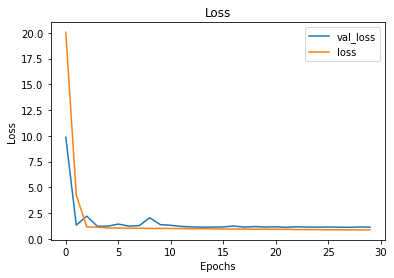

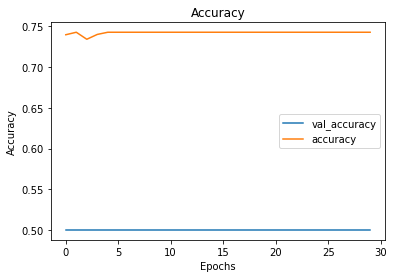

In [178]:
visualize_training_results(history_6)

In [179]:
model_results(model_6)

11/11 [==============================] - 0s 9ms/step - loss: 0.8600 - accuracy: 0.7407
training loss:0.86, training accuracy:0.74
validation loss:1.13, validation accuracy:0.5
testing loss:0.86, testing accuracy:0.74


We achieved even worse results using L1 regularization.

## Model 7: Dropout

The dropout technique of regularization works by dropping/ignoring (setting weights equal to zero) a random subset of nodes in a layer during training. Dropout can be applied to both input layers and hidden layers. It requires a rate argument that specifies the percentage of units to drop.

In [180]:
np.random.seed(123)

# initialize model
model_7 = Sequential()

# add Dense layers to the network
model_7.add(layers.Dense(20, activation='relu', input_shape=(input_shape,)))
# add dropout to first hidden layer
model_7.add(layers.Dropout(0.3))

model_7.add(layers.Dense(10, activation='relu'))
# add dropout to second hidden layer
model_7.add(layers.Dropout(0.3))

model_7.add(layers.Dense(7, activation='relu'))

model_7.add(layers.Dense(1, activation='sigmoid'))

In [181]:
model_7.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_7 = model_7.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 3s 17ms/step - loss: 0.7706 - accuracy: 0.6766 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 2s 14ms/step - loss: 0.6413 - accuracy: 0.7538 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 2s 14ms/step - loss: 0.6209 - accuracy: 0.7409 - val_loss: 0.7196 - val_accuracy: 0.5000
Epoch 4/30
163/163 [==============================] - 2s 14ms/step - loss: 0.6067 - accuracy: 0.7376 - val_loss: 0.7322 - val_accuracy: 0.5000
Epoch 5/30
163/163 [==============================] - 2s 14ms/step - loss: 0.5932 - accuracy: 0.7434 - val_loss: 0.7441 - val_accuracy: 0.5000
Epoch 6/30
163/163 [==============================] - 2s 15ms/step - loss: 0.5858 - accuracy: 0.7434 - val_loss: 0.7551 - val_accuracy: 0.5000
Epoch 7/30
163/163 [==============================] - 3s 16ms/step - loss: 0.5806 - accuracy: 0.7440 - val_loss: 0.7650 - val_accuracy: 0.5000

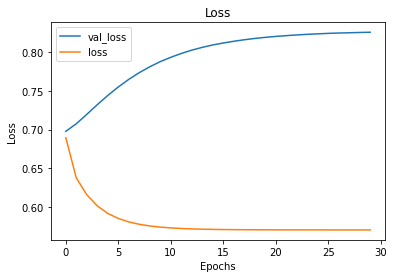

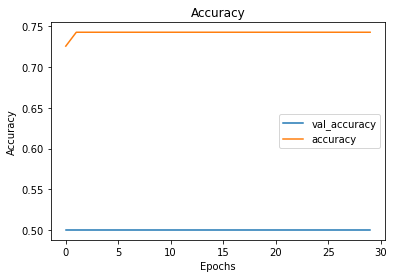

In [182]:
visualize_training_results(history_7)

In [183]:
model_results(model_7)

11/11 [==============================] - 0s 5ms/step - loss: 0.5723 - accuracy: 0.7407
training loss:0.57, training accuracy:0.74
validation loss:0.83, validation accuracy:0.5
testing loss:0.57, testing accuracy:0.74


Our last two models have decreased in performance significantly, converging at accuracies of .75 for test and train and .5 for validation.

The only acceptable results we achieved through regularization was using early stopping, which showed a slight decrease in training accuracy but an increase in validation accuracy and decrease in overfitting. We will declare model_4 our best model using an MLP. Next, we will begin using CNNs and see if we can achieve stronger results.

## Model 8: CNN

Convolutional neural networks (CNNs) are a different type of neural network that are very useful in image processing, as densely connected networks can grow very large with high resolution images. CNNs perform a convolution operation, which learns local patterns in different regions of an image and then applies those patterns to other regions. As the layers in a CNN increase, the patterns learned become increasingly larger and more complex based on features of the previous layers. The number of channels also increases as you move deeper into layers, each of which represents some aspect about the image. Below is some of the layer architecture included in CNNs:

**Conv2D**: a convolutional layer that uses a "filter" on an image to detect a certain feature about that image. The numbers following the Conv2D specifies how big the region is that is being applied to the image, (3,3) would use a 3x3 filter and apply it continuously over the image. The first number after Conv2D represents the number of channels, so Conv2D(32, (3,3) has 32 channels and uses a 3x3 filter.

**Padding**: Adds a layer of pixels around the image so that information around the edges is not lost when applying the filter over the original image. This can be configured by adding a padding argument to our convolutional layer; a value of "same" means the output of the layer will have the same shape as the input layer, preventing information from being lost.

**MaxPooling2D**: a pooling layer--this layer downsamples the previous convolutional layers in order to reduce our training time. The idea of max pooling is that taking the max values of all convolutions from a larger area of the original image will tell us whether or not a feature is present in that region, without having to keep all of the information we found during convolution. The 2 hyperparameters are filter size and stride size.

We are also going to try using data augmentation with our CNN models. Data augmentation can be done using the ImageDataGenerator, and it creates different images by randomly adjusting the original images in our dataset and trains the model on these augmented images. Applying data augmentation can improve the performance of our model, because the model will see "new" changed images in every epoch.

In [66]:
batch_size=32
train_steps = train_len/batch_size
train_steps

163.0

In [184]:
batch_size=32
val_steps = np.ceil(val_len/batch_size)
val_steps

10.0

In [68]:
# include data augmentation with our CNN models.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.3, 
                                   zoom_range=0.2, 
                                   horizontal_flip=False)

In [69]:
# new train generator with batch size of 32
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(target_size),
                                                    batch_size=32,
                                                    class_mode=class_mode)

Found 5216 images belonging to 2 classes.


In [192]:
# don't perform augmentation on your test and validation set
test_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(test_dir,
                                                         target_size=(target_size),
                                                         batch_size=32,
                                                         class_mode=class_mode)

val_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(val_dir,
                                                         target_size=(target_size),
                                                         batch_size=32,
                                                         class_mode=class_mode)

Found 324 images belonging to 2 classes.
Found 316 images belonging to 2 classes.


In [71]:
np.random.seed(123)

model_8 = Sequential()
model_8.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Flatten())
model_8.add(layers.Dense(64, activation='relu'))
model_8.add(layers.Dense(1, activation='sigmoid'))

In [72]:
model_8.compile(optimizer=opt,
                loss=loss,
                metrics=metrics)

model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In the above summary of our CNN model, we see that our data remains in multi-dimensional matrices until it reaches the flatten step, where the data is then ready to enter the dense layers of the network. This model has over 1 million parameters, but the number of parameters in the convolutional steps remains relatively small. This speaks to how efficient the CNN is in processing image data. The shape increases as the convolutional layers increase because each layer becomes increasingly complex, representing more abstract features about the image, and using information discovered in previous layers.

In [73]:
history_8 = model_8.fit(train_generator, 
                    steps_per_epoch=train_steps, 
                    epochs=30, 
                    validation_data=val_generator)

Epoch 1/30
163/163 [==============================] - 182s 1s/step - loss: 0.5882 - accuracy: 0.7235 - val_loss: 0.6895 - val_accuracy: 0.5032
Epoch 2/30
163/163 [==============================] - 180s 1s/step - loss: 0.5030 - accuracy: 0.7535 - val_loss: 0.4763 - val_accuracy: 0.7753
Epoch 3/30
163/163 [==============================] - 180s 1s/step - loss: 0.3715 - accuracy: 0.8479 - val_loss: 0.4927 - val_accuracy: 0.7658
Epoch 4/30
163/163 [==============================] - 180s 1s/step - loss: 0.3267 - accuracy: 0.8613 - val_loss: 0.6572 - val_accuracy: 0.6994
Epoch 5/30
163/163 [==============================] - 181s 1s/step - loss: 0.2858 - accuracy: 0.8765 - val_loss: 0.4411 - val_accuracy: 0.7816
Epoch 6/30
163/163 [==============================] - 180s 1s/step - loss: 0.2671 - accuracy: 0.8956 - val_loss: 0.5079 - val_accuracy: 0.7658
Epoch 7/30
163/163 [==============================] - 181s 1s/step - loss: 0.2556 - accuracy: 0.8961 - val_loss: 0.4693 - val_accuracy: 0.7658

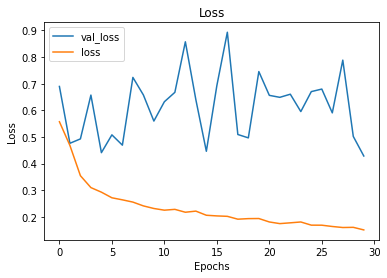

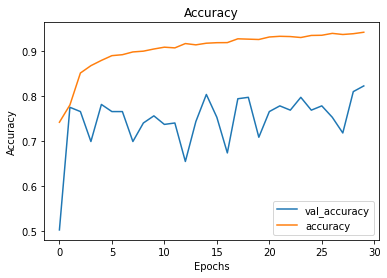

In [74]:
visualize_training_results(history_8)

In [75]:
#write new function that provides results of CNN models
def cnn_model_results(model):
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(val_generator)
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"training loss:{round(train_loss,2)}, training accuracy:{round(train_acc,2)}")
    
    print(f"validation loss:{round(val_loss,2)}, validation accuracy:{round(val_acc,2)}")
    
    print(f"testing loss:{round(test_loss,2)}, testing accuracy:{round(test_acc,2)}")

In [76]:
cnn_model_results(model_8)

11/11 [==============================] - 5s 493ms/step - loss: 0.1089 - accuracy: 0.9784
training loss:0.18, training accuracy:0.93
validation loss:0.43, validation accuracy:0.82
testing loss:0.11, testing accuracy:0.98


We are already seeing much stronger results than in our MLP models, with testing results that are actually better than our training results. These are also our strongest validation scores yet.

## Model 9: CNN wih Additional Layers and Units

The training results of our model are much closer to the testing results than any of the models we have run so far, suggesting this model is much less overfit. Let's see if adding layers and units to our model can help improve the performance at all.

In [77]:
np.random.seed(123)

model_9 = Sequential()
model_9.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
model_9.add(layers.MaxPooling2D((2, 2)))

# increase layer from 32 to 64 units
model_9.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_9.add(layers.MaxPooling2D((2, 2)))

model_9.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_9.add(layers.MaxPooling2D((2, 2)))

# add a new convolutional layer with 128 units and 3x3 filter
model_9.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_9.add(layers.MaxPooling2D((2, 2)))

model_9.add(layers.Flatten())
model_9.add(layers.Dense(64, activation='relu'))
model_9.add(layers.Dense(1, activation='sigmoid'))

model_9.compile(optimizer=opt,
                loss=loss,
                metrics=metrics)

In [78]:
history_9 = model_9.fit(train_generator, 
                    steps_per_epoch=train_steps, 
                    epochs=30,
                    validation_data=val_generator)

Epoch 1/30
163/163 [==============================] - 195s 1s/step - loss: 0.6055 - accuracy: 0.7303 - val_loss: 0.7864 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 208s 1s/step - loss: 0.5583 - accuracy: 0.7429 - val_loss: 0.7435 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 208s 1s/step - loss: 0.5161 - accuracy: 0.7380 - val_loss: 0.5407 - val_accuracy: 0.7184
Epoch 4/30
163/163 [==============================] - 205s 1s/step - loss: 0.4533 - accuracy: 0.7995 - val_loss: 0.6740 - val_accuracy: 0.6171
Epoch 5/30
163/163 [==============================] - 205s 1s/step - loss: 0.3799 - accuracy: 0.8337 - val_loss: 0.4301 - val_accuracy: 0.7975
Epoch 6/30
163/163 [==============================] - 205s 1s/step - loss: 0.3361 - accuracy: 0.8549 - val_loss: 0.3926 - val_accuracy: 0.7975
Epoch 7/30
163/163 [==============================] - 203s 1s/step - loss: 0.2960 - accuracy: 0.8755 - val_loss: 0.6003 - val_accuracy: 0.7247

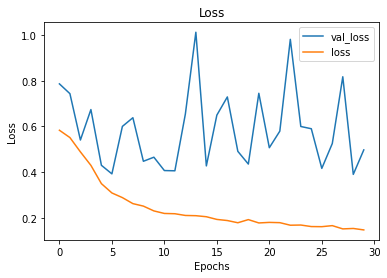

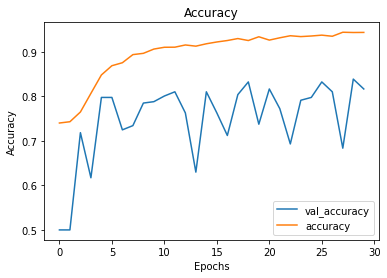

In [200]:
visualize_training_results(history_9)

In [79]:
cnn_model_results(model_9)

11/11 [==============================] - 6s 535ms/step - loss: 0.1020 - accuracy: 0.9753
training loss:0.15, training accuracy:0.95
validation loss:0.5, validation accuracy:0.82
testing loss:0.1, testing accuracy:0.98


Our training results improved slightly. There does not appear to be much overfitting in the model, as our accuracy results are nearly the same for training and testing. Let's see if adding padding to our convolutional layers will change the results at all.

## Model 10: CNN with Padding

Since we are starting to get better results, we are going to begin training our models for longer epochs. However, to prevent overfitting, we will implement early stopping as we did in model 4. This next model will include padding and early stopping.

In [194]:
np.random.seed(123)

model_10 = Sequential()

# add padding argument to each convolutional layer
model_10.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                        input_shape=(150 ,150,  3)))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same'))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Flatten())
model_10.add(layers.Dense(64, activation='relu'))
model_10.add(layers.Dense(1, activation='sigmoid'))

model_10.compile(optimizer=opt,
                loss=loss,
                metrics=metrics)

In [195]:
history_10 = model_10.fit(train_generator, 
                    steps_per_epoch=train_steps, 
                    epochs=30,
                    validation_data=val_generator)

Epoch 1/30
163/163 [==============================] - 287s 2s/step - loss: 0.5874 - accuracy: 0.7412 - val_loss: 0.8096 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 278s 2s/step - loss: 0.5350 - accuracy: 0.7461 - val_loss: 0.9820 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 276s 2s/step - loss: 0.4525 - accuracy: 0.7918 - val_loss: 0.5204 - val_accuracy: 0.7247
Epoch 4/30
163/163 [==============================] - 282s 2s/step - loss: 0.3914 - accuracy: 0.8229 - val_loss: 0.4481 - val_accuracy: 0.7722
Epoch 5/30
163/163 [==============================] - 266s 2s/step - loss: 0.3129 - accuracy: 0.8707 - val_loss: 0.4117 - val_accuracy: 0.8070
Epoch 6/30
163/163 [==============================] - 273s 2s/step - loss: 0.2768 - accuracy: 0.8883 - val_loss: 0.3708 - val_accuracy: 0.8038
Epoch 7/30
163/163 [==============================] - 251s 2s/step - loss: 0.2735 - accuracy: 0.8851 - val_loss: 0.7152 - val_accuracy: 0.6867

In [197]:
cnn_model_results(model_10)

11/11 [==============================] - 9s 767ms/step - loss: 0.1328 - accuracy: 0.9568
training loss:0.13, training accuracy:0.95
validation loss:0.66, validation accuracy:0.75
testing loss:0.13, testing accuracy:0.96


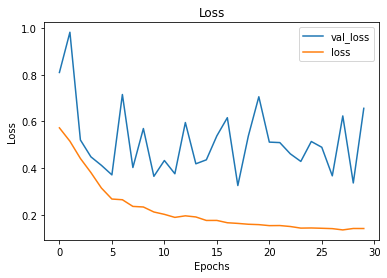

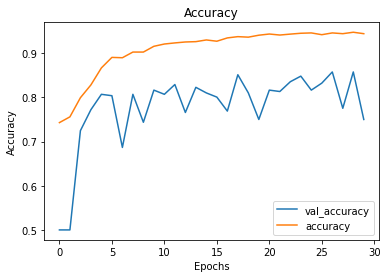

In [198]:
visualize_training_results(history_10)

We were able to maintain strong results by using padding. To make sure we are getting the strongest results possible, we are going to train this model with more epochs and implement early stopping to prevent the model from overfitting.

In [186]:
early_stopping = [EarlyStopping(monitor='val_loss',patience=10),
                  ModelCheckpoint(filepath='best_model_2.h5', monitor='val_loss', save_best_only=True)]

In [187]:
history_10 = model_10.fit(train_generator, 
                    steps_per_epoch=train_steps, 
                    epochs=50,
                    callbacks=early_stopping,
                    validation_data=val_generator,
                            validation_steps=10)

Epoch 1/50
163/163 [==============================] - 227s 1s/step - loss: 0.6026 - accuracy: 0.7484 - val_loss: 0.8095 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 245s 2s/step - loss: 0.5681 - accuracy: 0.7383 - val_loss: 0.7457 - val_accuracy: 0.5000
Epoch 3/50
163/163 [==============================] - 242s 1s/step - loss: 0.5246 - accuracy: 0.7414 - val_loss: 0.9752 - val_accuracy: 0.5000
Epoch 4/50
163/163 [==============================] - 246s 2s/step - loss: 0.4468 - accuracy: 0.7970 - val_loss: 0.4454 - val_accuracy: 0.7975
Epoch 5/50
163/163 [==============================] - 242s 1s/step - loss: 0.3807 - accuracy: 0.8264 - val_loss: 0.4327 - val_accuracy: 0.7848
Epoch 6/50
163/163 [==============================] - 239s 1s/step - loss: 0.3364 - accuracy: 0.8635 - val_loss: 0.4126 - val_accuracy: 0.7943
Epoch 7/50
163/163 [==============================] - 246s 2s/step - loss: 0.2996 - accuracy: 0.8803 - val_loss: 0.4824 - val_accuracy: 0.7627

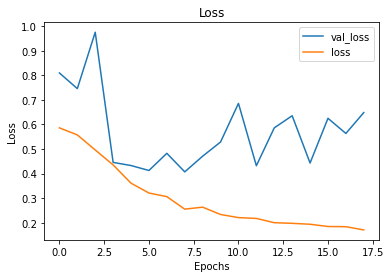

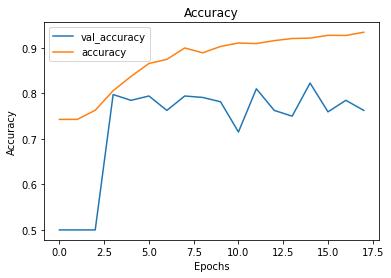

In [189]:
visualize_training_results(history_10)

In [190]:
model_10 = load_model('best_model_2.h5')

In [193]:
cnn_model_results(model_10)

11/11 [==============================] - 8s 642ms/step - loss: 0.2196 - accuracy: 0.9228
training loss:0.23, training accuracy:0.91
validation loss:0.41, validation accuracy:0.79
testing loss:0.22, testing accuracy:0.92


Implementing longer training times improved our model even further, however, there is still some slight overfitting of the training data compared to the validation data. We are going to try applying dropout to the dense layer in our model to see if this improves the overfitting further.

## Model 11: CNN with Dropout

In [88]:
np.random.seed(123)

model_11 = Sequential()

# add padding argument to each convolutional layer
model_11.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                        input_shape=(150 ,150,  3)))
model_11.add(layers.MaxPooling2D((2, 2)))

model_11.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same'))
model_11.add(layers.MaxPooling2D((2, 2)))

model_11.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_11.add(layers.MaxPooling2D((2, 2)))

model_11.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_11.add(layers.MaxPooling2D((2, 2)))

model_11.add(layers.Flatten())
model_11.add(layers.Dense(64, activation='relu'))
model_11.add(layers.Dropout(0.3))
model_11.add(layers.Dense(1, activation='sigmoid'))

model_11.compile(optimizer=opt,
                loss=loss,
                metrics=metrics)

In [89]:
history_11 = model_11.fit(train_generator, 
                    steps_per_epoch=train_steps, 
                    epochs=50,
                    callbacks=early_stopping,
                    validation_data=val_generator,
                            validation_steps=10)

Epoch 1/50
163/163 [==============================] - 219s 1s/step - loss: 0.6002 - accuracy: 0.7357 - val_loss: 0.7668 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 216s 1s/step - loss: 0.5735 - accuracy: 0.7307 - val_loss: 0.6798 - val_accuracy: 0.5000
Epoch 3/50
163/163 [==============================] - 216s 1s/step - loss: 0.5112 - accuracy: 0.7544 - val_loss: 0.5026 - val_accuracy: 0.7943
Epoch 4/50
163/163 [==============================] - 215s 1s/step - loss: 0.4437 - accuracy: 0.8074 - val_loss: 0.4378 - val_accuracy: 0.7975
Epoch 5/50
163/163 [==============================] - 218s 1s/step - loss: 0.3978 - accuracy: 0.8174 - val_loss: 0.4425 - val_accuracy: 0.7848
Epoch 6/50
163/163 [==============================] - 217s 1s/step - loss: 0.3133 - accuracy: 0.8714 - val_loss: 0.4948 - val_accuracy: 0.7627
Epoch 7/50
163/163 [==============================] - 216s 1s/step - loss: 0.3045 - accuracy: 0.8698 - val_loss: 0.5211 - val_accuracy: 0.7595

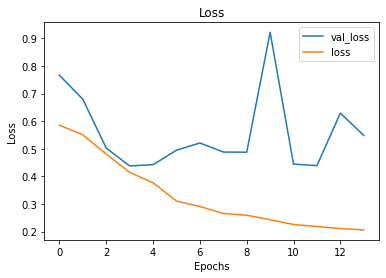

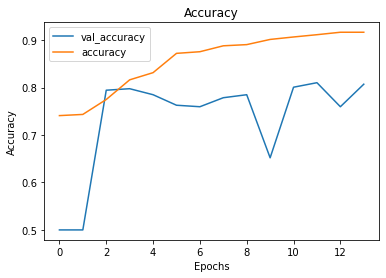

In [90]:
visualize_training_results(history_11)

In [91]:
cnn_model_results(model_11)

11/11 [==============================] - 6s 506ms/step - loss: 0.1639 - accuracy: 0.9228
training loss:0.18, training accuracy:0.92
validation loss:0.55, validation accuracy:0.81
testing loss:0.16, testing accuracy:0.92


In [92]:
model_11.save('final_x_ray_model.h5')

In this model, our accuracy scores are closer together than in any previous model, with validation accuracy of 0.81 compared to testing and training accuracy of 0.92. We also have lower loss values for our train and test set than model 10. Although model 9 achieved similar results and better training scores, we have more confidence that this model will work on an unseen dataset, since the use of dropout combats overfitting. We will use this as our final model.

# Model Evaluation

## Final Model Evaluation Metrics

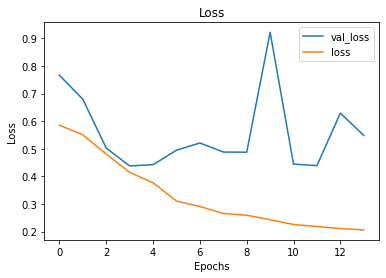

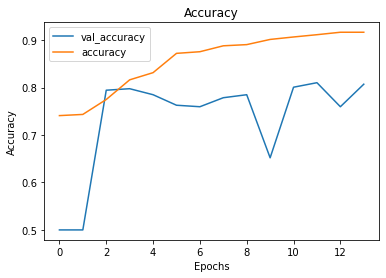

In [201]:
visualize_training_results(history_11)

In [94]:
from keras.models import load_model
model = load_model('final_x_ray_model.h5')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 75, 75, 64)        32832     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 18, 18, 128)     

Our final model has 808,193 parameters, with 4 different convolutional layers, 4 pooling layers and 1 dense hidden layer.

## Visualizing Intermediate Layers

We are now going to visualize the feature maps created during training. In a CNN layer, a filter is applied over a previous image to create a new representation of the image, or a feature map.

First, we'll load one particular image from our dataset as an example of how our CNN is working.

(1, 150, 150, 3)


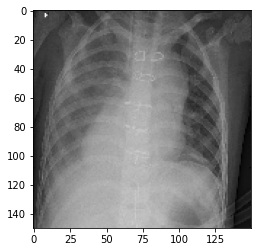

In [95]:
from keras.preprocessing import image
img_path = '/Users/saman/x_ray_images/train/PNEUMONIA/person2_bacteria_4.jpeg'


img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

We can see from the model summary above that the first CNN layer has 32 channels. Running the analysis below will show us what all 32 channels of this first layer look like.

In [96]:
from keras import models
# pull in the first 8 layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# plt.show()

(1, 150, 150, 32)


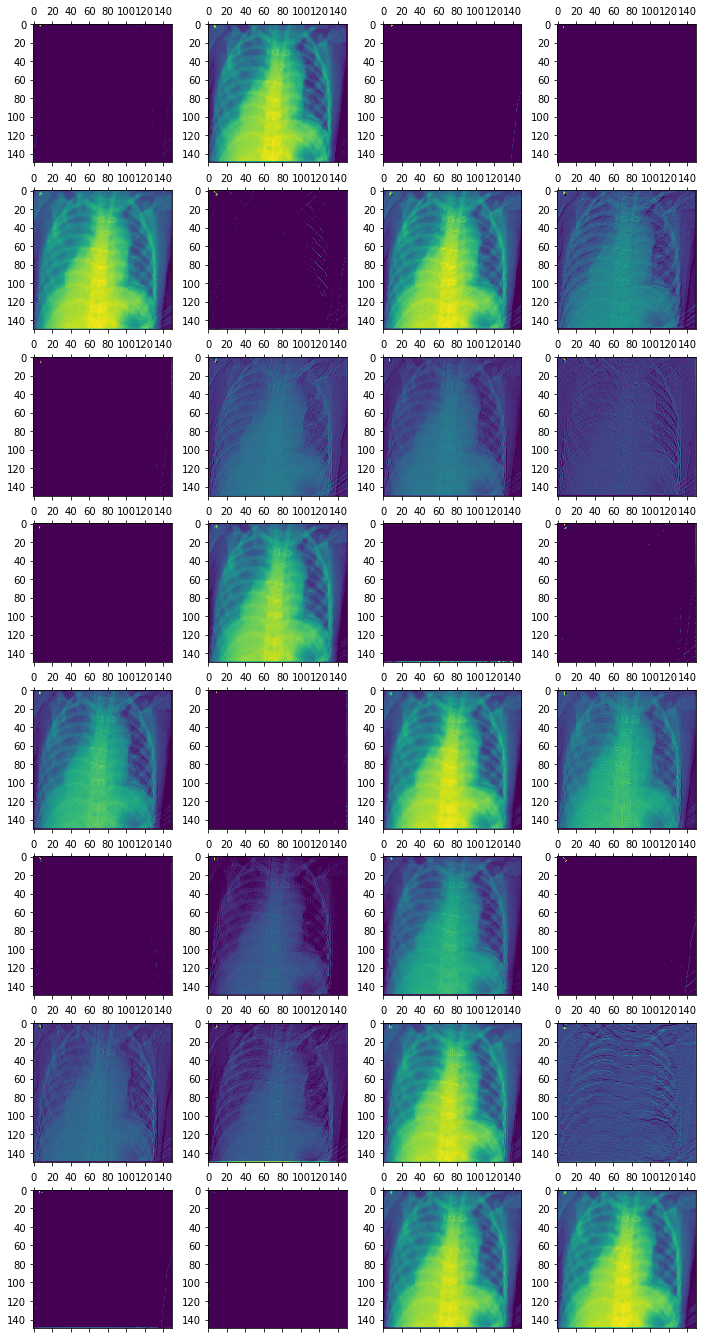

In [97]:
# shows the result of the first layer activation for the 32 channels
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

We can also visualize what each of the activation layers look like. The below code returns the 19th channel of all 8 activation layers.

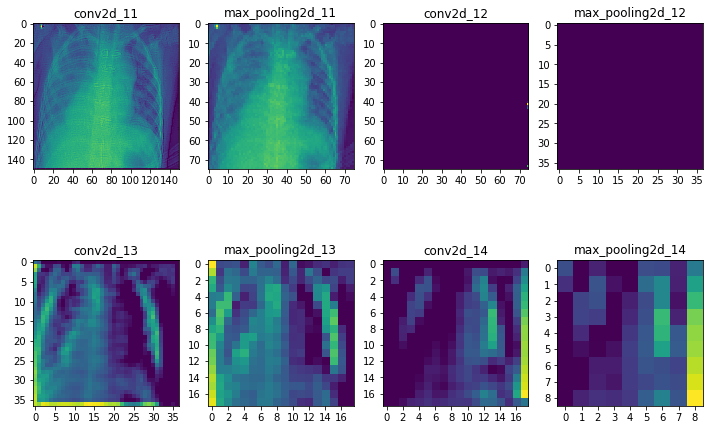

In [98]:
# shows the first 8 layers
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

    # preview the 19th channel of the first 8 activations
for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 19], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

The layers build on each other as the CNN tries to find more and more abstract patterns/features; you can see the visuals getting more and more abstract as the layers go on. Any blank images mean that particular feature was not found in the current image. It becomes very clear from looking at these images that some data is lost from the image during the pooling layer, but that the most important information is kept and carried on to the next layer.

## Confusion Matrix

Lastly, we are going to create a confusion matrix to keep track of the predictions made in our final model. Although we have a good sense of accuracy, we do not have other important metrics such as recall or precision.

In [160]:
# create a new test generator so that we make sure our images don't get shuffled
test_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(test_dir, 
                                                         target_size=(150, 150),
                                                         batch_size=32, 
                                                         shuffle=False)

Found 324 images belonging to 2 classes.


In [161]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model_11.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.round(predictions)

In [162]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [163]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(true_classes, predicted_classes, 
                                       target_names=['Normal','Pneumonia'])
print(report)

              precision    recall  f1-score   support

      Normal       0.88      0.81      0.84        84
   Pneumonia       0.94      0.96      0.95       240

    accuracy                           0.92       324
   macro avg       0.91      0.89      0.90       324
weighted avg       0.92      0.92      0.92       324



In [164]:
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[ 68,  16],
       [  9, 231]], dtype=int64)

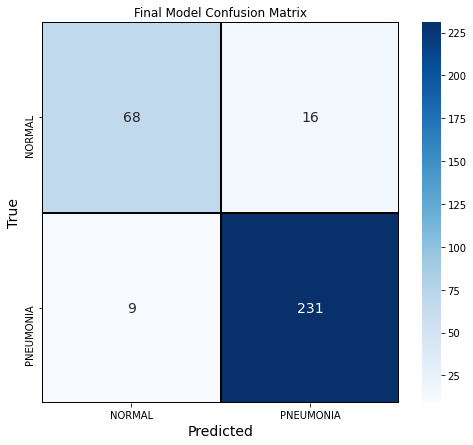

In [165]:
plt.figure(figsize = (8,7))

sns.heatmap(cm, cmap="Blues", linecolor = 'black' , annot_kws={"size": 14},linewidth = 1, annot = True, fmt='')
plt.xticks((.5,1.5),['NORMAL', 'PNEUMONIA'])
plt.yticks((.5,1.5),['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Final Model Confusion Matrix')
plt.show()

It looks like we achieved precision of 0.94, recall of 0.96 and F1 score of 0.95. (Precision is the true positives of all predicted positives; recall is the true positives out of all actual positives). 299 of our total test predictions were correct predictions, and we only had 9 false negatives and 16 false positives. This is a very good sign that our model is not missing many cases where a patient has pneumonia and the model predicted they did not.

## Final Conclusions

**Use the final model to decide which patients are at highest risk.** Given the limited capacity at the COVID clinic, the providers should use our model to determine which patients need to be monitored closely. At times during high spikes in cases, the providers can further investigate any patients tagged as having pneumonia. Since COVID can quickly worsen in patients, the model will allow these patients to get the care they need quicker than if the doctors needed to review every single x-ray of every COVID patient.

**Run each image through multiple models.** Our last few CNN models we ran had similar performance but slightly different structure. We would recommend that if the clinic and attached hospital are particularly overwhelmed and reaching capacity, that they run the images through 3 of the CNN models. If a patient is classified as having pneumonia 2 or more times in the models, these patients can be sent directly to the hospital for further treatment. The clinic can continue to monitor the rest of the patients without sending them to the hospital for immediate attention. Using multiple models can help providers further make decisions at times of high constraints.

**Continue to train the model.** At times where cases drop and the providers have more capacity to look at patients and their x-rays, they should add these reviewed x-rays to our dataset. We can then train the model on our data using the new labeled samples, which should continually improve our model's ability to classify. This is especially important for normal, non-pneumonia x-rays, since there is a class imbalance and not as many of these images. Doing this work during slower times will help the model make better decision in times of high cases.